In [1]:
import pandas as pd
from datetime import datetime
import joblib
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
# Load pd_train
pd_train = pd.read_parquet("data/training_class_x15.paruet")
pd_train["label"] = pd_train["Class"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_train.shape)

(19856, 16094)


In [3]:
# Load pd_test
pd_test = pd.read_parquet("data/testing_class.parquet")
pd_test["label"] = pd_test["Class"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)

(286, 16094)


# Feature selection

In [5]:
# feature selected
feat_selected = [
    "FP17",
    "FP143",
    "FP1007",
    "ExtFP316",
    "ExtFP46",
    "ExtFP915",
    "MACCSFP153",
    "KRFP298",
    "SubFPC2",
    "KRFPC401",
    "APC2D5_N_N",
]

In [6]:
# Check the actual column names in the dataset
actual_columns = pd_train.columns

# Update the fingerprints dictionary with existing column names
feature_groups = {
    "FP": [col for col in actual_columns if col.startswith("FP")],
    "ExtFP": [col for col in actual_columns if col.startswith("ExtFP")],
    "EstateFP": [col for col in actual_columns if col.startswith("EstateFP")],
    "GraphFP": [col for col in actual_columns if col.startswith("GraphFP")],
    "MACCSFP": [col for col in actual_columns if col.startswith("MACCSFP")],
    "PubchemFP": [col for col in actual_columns if col.startswith("PubchemFP")],
    "SubFP": [col for col in actual_columns if col.startswith("SubFP")],
    "SubFPC": [col for col in actual_columns if col.startswith("SubFPC")],
    "KRFP": [col for col in actual_columns if col.startswith("KRFP")],
    "KRFPC": [col for col in actual_columns if col.startswith("KRFPC")],
    "AD2D": [col for col in actual_columns if col.startswith("AD2D")],
    "APC2D": [col for col in actual_columns if col.startswith("APC2D")],
}
len(feature_groups["FP"])

1024

In [11]:
# Select the features
drop_group_features = ["MACCSFP", "PubchemFP", "SubFPC"]
feat_selected = []
for group, features in feature_groups.items():
    if group not in drop_group_features:
        feat_selected.extend(features)

feat_selected = list(set(feat_selected))
print(len(feat_selected))

14966


In [19]:
# train val split with sklearn
from sklearn.model_selection import train_test_split

features = [col for col in pd_train.columns if col not in ["Class", "label"]]
# features = feat_selected
X_train, X_val, y_train, y_val = train_test_split(
    pd_train[features], pd_train["label"], test_size=0.1, random_state=42
)
X_test = pd_test[features]
y_test = pd_test["label"]

print("Train size: ", X_train.shape)
print("Val size: ", X_val.shape)
print("Test size: ", X_test.shape)

Train size:  (17870, 16092)
Val size:  (1986, 16092)
Test size:  (286, 16092)


# PCA

In [20]:
from sklearn.decomposition import PCA

# Assuming you have the data loaded in train_data, val_data, and test_data
# Apply PCA to reduce dimensions to 100
pca = PCA(n_components=100, svd_solver='randomized', whiten=True)

# Fit PCA on the training data and apply the transformation to all datasets
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

# Output shapes
print("Train size after PCA:", X_train.shape)
print("Val size after PCA:", X_val.shape)
print("Test size after PCA:", X_test.shape)


Train size after PCA: (17870, 100)
Val size after PCA: (1986, 100)
Test size after PCA: (286, 100)


# Train with XGBoost

In [25]:
%%time
import xgboost as xgb

# param_init = {
#     "objective": "binary:logistic",
#     "booster": "gbtree",
#     "max_depth": 4,
#     "n_estimators": 1000,
#     "learning_rate": 0.025,
#     "subsample": 0.5,
#     "colsample_bytree": 0.2,
#     "colsample_bylevel": 0.3,
#     "random_state": 42,
#     #
#     # "silent": True,
#     "n_jobs": 10,
#     #
#     "tree_method": "hist",
#     "grow_policy": "lossguide",
#     "eval_metric": "auc",
#     "early_stopping_rounds": 250,
# }

# param_fit = {
#     "verbose": 200,
#     "eval_set": [(X_train, y_train), (X_test, y_test), (X_val, y_val)],
# }

# Adjusted XGBoost parameters
# param_init = {
#     "objective": "binary:logistic",
#     "booster": "gbtree",
#     "max_depth": 6,  # Slightly deeper trees to capture more complexity
#     "n_estimators": 700,  # Reduce the number of estimators as we increase learning rate
#     "learning_rate": 0.05,  # Slightly higher learning rate for faster convergence
#     "subsample": 0.6,  # Increased for better generalization
#     "colsample_bytree": 0.3,  # Increased to allow more features
#     "colsample_bylevel": 0.6,  # Increased to improve feature diversity at each level
#     "random_state": 42,
#     "n_jobs": 10,
#     "tree_method": "hist",  # If you have a GPU, you can use "gpu_hist"
#     "grow_policy": "lossguide",
#     "eval_metric": "auc",
#     "early_stopping_rounds": 500,  # Reduce early stopping rounds for faster convergence
# }

param_init = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "max_depth": 3,  # Shallower trees due to reduced features
    "n_estimators": 1000,  # Fewer estimators with smaller data and features
    "learning_rate": 0.05,  # Steady learning rate
    "subsample": 0.8,  # Higher sample size per tree
    "colsample_bytree": 0.8,  # Use more features per tree
    "colsample_bylevel": 0.8,  # Use more features at each level
    "random_state": 42,
    "n_jobs": 10,
    "tree_method": "hist",  # Efficient for small datasets, consider "gpu_hist" if using GPU
    "grow_policy": "lossguide",
    "eval_metric": "auc",
    "early_stopping_rounds": 300,  # Reduced for faster convergence
}

param_fit = {
    "verbose": 200,
    "eval_set": [(X_train, y_train), (X_val, y_val), (X_test, y_test)],
}

xgb_model = xgb.XGBClassifier(**param_init)
xgb_model.fit(X_train, y_train, **param_fit)
evals_result = xgb_model.evals_result()

[0]	validation_0-auc:0.66401	validation_1-auc:0.65589	validation_2-auc:0.56338
[200]	validation_0-auc:0.95860	validation_1-auc:0.95266	validation_2-auc:0.88061
[400]	validation_0-auc:0.97600	validation_1-auc:0.97131	validation_2-auc:0.89231
[600]	validation_0-auc:0.98283	validation_1-auc:0.97959	validation_2-auc:0.89502
[797]	validation_0-auc:0.98634	validation_1-auc:0.98333	validation_2-auc:0.89767
CPU times: total: 12 s
Wall time: 4.28 s


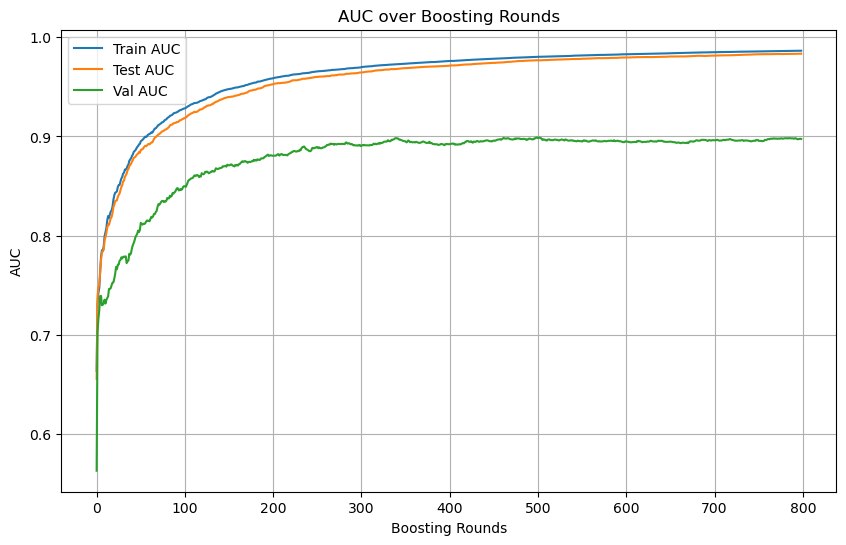

In [26]:
import matplotlib.pyplot as plt

# Extract the AUC values from evals_result
epochs = len(evals_result['validation_0']['auc'])
x_axis = range(0, epochs)

# Plot AUC for the training and validation sets
plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['validation_0']['auc'], label='Train AUC')
plt.plot(x_axis, evals_result['validation_1']['auc'], label='Test AUC')
plt.plot(x_axis, evals_result['validation_2']['auc'], label='Val AUC')

# Add labels, title, and legend
plt.xlabel('Boosting Rounds')
plt.ylabel('AUC')
plt.title('AUC over Boosting Rounds')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [15]:
# save model with joblib current datetime
# joblib.dump(xgb_model, f"models/xgb_{datetime.now().strftime('%Y%m%d_%H%M%S')}.joblib")
joblib.dump(xgb_model, f"models/xgb_latest.joblib")

['models/xgb_latest.joblib']

# Model evaluates

In [16]:
# load model
xgb_model = joblib.load("models/xgb_latest.joblib")

In [25]:
# #
# n_features = X_train.shape[1]
# fig, ax = plt.subplots(figsize=(10, n_features // 10))
# plot_importance(xgb_model, ax=ax)
# plt.show()

In [27]:
# print top features importance
top_features = xgb_model.get_booster().get_fscore()
top_features = sorted(top_features.items(), key=lambda x: x[1], reverse=True)
print("Top features importance")
for i, (feature, importance) in enumerate(top_features[:20]):
    print(f"{i+1}. {feature}: {importance}")

Top features importance
1. f42: 106.0
2. f99: 104.0
3. f87: 100.0
4. f4: 97.0
5. f71: 91.0
6. f9: 84.0
7. f63: 84.0
8. f98: 84.0
9. f5: 79.0
10. f45: 79.0
11. f67: 79.0
12. f30: 75.0
13. f14: 74.0
14. f44: 74.0
15. f95: 74.0
16. f57: 72.0
17. f83: 71.0
18. f6: 69.0
19. f74: 69.0
20. f80: 69.0


In [28]:
# check AUC
y_train_pred = xgb_model.predict_proba(X_train)[:, 1]
y_val_pred = xgb_model.predict_proba(X_val)[:, 1]
y_test_pred = xgb_model.predict_proba(X_test)[:, 1]

print("Train AUC: ", roc_auc_score(y_train, y_train_pred))
print("Val AUC: ", roc_auc_score(y_val, y_val_pred))
print("Test AUC: ", roc_auc_score(y_test, y_test_pred))

Train AUC:  0.9801980640479778
Val AUC:  0.9767508372848758
Test AUC:  0.8989209885137487


In [12]:
def visualize_auc(y, y_pred):
    auc_value = roc_auc_score(y, y_pred)
    res01 = roc_curve(y, y_pred)

    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    lw = 2
    ax1.plot(res01[0], res01[1], color="darkorange", lw=lw, label="ROC")
    ax1.plot([0, 1], [0, 1], color="navy", label="Random", lw=lw, linestyle="--")
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_title("AUC = %0.5f" % (auc_value))
    ax1.legend(loc="lower right")

    ax2.set_title("Set (size: {})".format(y.shape[0]))
    ax2.hist(y_pred, bins=200)

    plt.show()

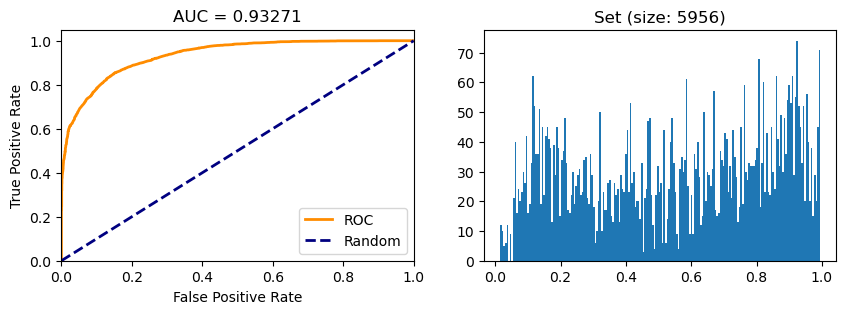

In [20]:
visualize_auc(y_train, y_train_pred)

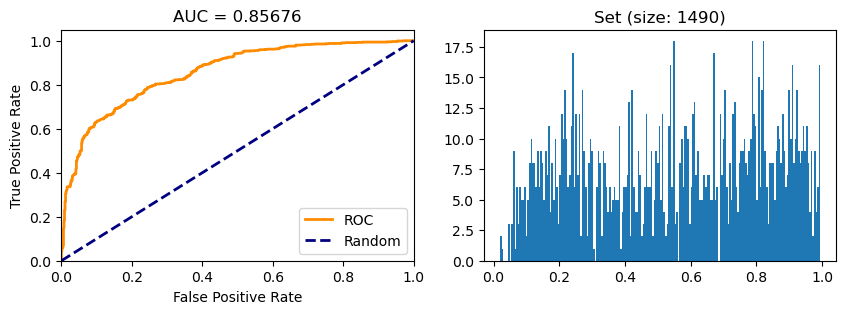

In [21]:
visualize_auc(y_val, y_val_pred)

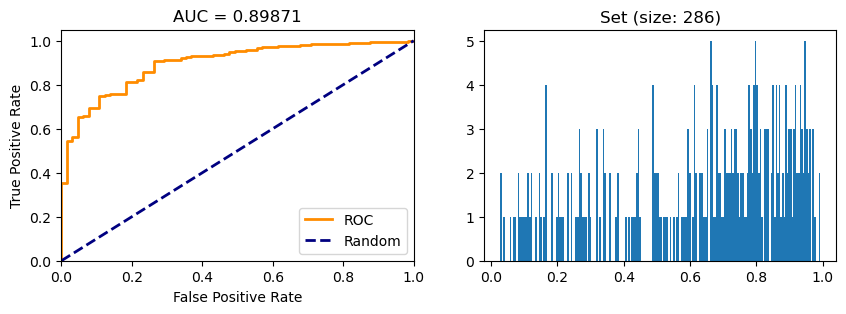

In [13]:
visualize_auc(y_test, y_test_pred)